# Analysis of Zenodo data

## Import packages

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import yaml

plt.rcParams.update({'font.size': 20})

## Load data

In [20]:
datasets = pd.read_csv("../zenodo_datasets.tsv", sep="\t")
print(f"Found {datasets.shape[0]} datasets.")
files = pd.read_csv("../zenodo_files.tsv", sep="\t")
print(f"Found {files.shape[0]} files.")

Found 817 datasets.
Found 113502 files.


/tmp/ipykernel_154502/1780778853.py:3: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  files = pd.read_csv("../zenodo_files.tsv", sep="\t")


Merge both dataframes.
One dataset can be associated to many files.

In [21]:
tab = pd.merge(files, datasets, how="left", on=["dataset_id", "origin"], validate="many_to_one")
print(f"Dataframe has {tab.shape[0]} entries.")

Dataframe has 113502 entries.


## Read query parameters

In [22]:
def read_query_file(filename):
    """File query.yml parser.

    This function parses the query file.

    Parameters
    ----------
    filename : str
        Filename for query parameters.
    
    Returns
    -------
    file_types : dict
        Dictionary with type, engine, keywords to use and category
    """
    with open(filename, "r") as param_file:
        data_loaded = yaml.safe_load(param_file)
    file_types = data_loaded["file_types"]
    return file_types

In [23]:
dico_file_types = read_query_file("../query.yml")

ext_gromacs = []
ext_namd = []
ext_amber = []

list_coordinate = []
list_trajectory = []
list_topology = []

for dico in dico_file_types:
    if dico["engine"] == "gromacs":
        ext_gromacs.append(dico["type"])
    elif dico["engine"] == "namd":
        ext_namd.append(dico["type"])
    elif dico["engine"] == "amber":
        ext_amber.append(dico["type"])
    
    if dico["category"] == "coordinate":
        list_coordinate.append(dico["type"])
    elif dico["category"] == "topology":
        list_topology.append(dico["type"])
    elif dico["category"] == "trajectory":
        list_trajectory.append(dico["type"])

ext_all = ext_gromacs + ext_namd + ext_amber
        
# The filetype "top" is included in both Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

## Compute number of keywords for each dataset

In [24]:
def count_keywords(keywords):
    """Count number of keywords.
    
    Keywords are separated by ; or ,
    
    Parameters
    ----------
    keywords : str
        Keywords.
    
    Returns
    -------
    int
        Number of keywords.
    """
    keywords = str(keywords)
    if keywords and keywords not in ["None", "nan"]:
        keywords_lst = keywords.replace(",", ";").split(";")
        return len(keywords_lst)
    else:
        return 0

datasets["keywords_nb"] = datasets["keywords"].apply(count_keywords)
datasets["keywords_nb"].value_counts()
print(f"Average number of keywords per dataset: {datasets['keywords_nb'].mean():.2f}")

Average number of keywords per dataset: 2.36


## Define MD engine per file

In [25]:
def define_md_engine(file_type):
    """Define MD engine based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Name of MD engine.
    """
    if file_type in ext_gromacs:
        return "gromacs"
    elif file_type in ext_namd:
        return "namd"
    elif file_type in ext_amber:
        return "amber"
    else:
        return "none"

tab["engine_MD"] = tab["file_type"].apply(define_md_engine)
tab["engine_MD"].value_counts()

none       62206
gromacs    42092
amber       5157
namd        4047
Name: engine_MD, dtype: int64

## Define file category

In [26]:
def define_file_category(file_type):
    """Define file category based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Category.
    """
    if file_type in list_coordinate:
        return "coordinate"
    elif file_type in list_topology:
        return "topology"
    elif file_type in list_trajectory:
        return "trajectory"
    else:
        return "none"

tab["category"] = tab["file_type"].apply(define_file_category)
tab["category"].value_counts()

none          62206
trajectory    27339
topology      12350
coordinate    11607
Name: category, dtype: int64

## Extract year from date

In [27]:
tab["year"] = tab["date_creation"].apply(lambda x: int(x[:4]))
datasets["year"] = datasets["date_creation"].apply(lambda x: int(x[:4]))

## Available mdp and gro files to download

In [29]:
(tab
    .query("from_zip_file == False")
    .query("file_type in ['mdp', 'gro']")
    .groupby("dataset_id")
    .size()
    .shape[0] # total number of datasets to download data from
)

480

## Remove zip files

We remove zip files but not their content.

In [31]:
files_nb_before = tab.shape[0]
tab = tab[tab["file_type"] != "zip"]
print(f"Remove {files_nb_before - tab.shape[0]} zip files.")

Remove 0 zip files.


## Total size of all files

- in TB
- zip files excluded 

In [32]:
print(f"Total file size: {tab['file_size'].sum()/10**12:.1f} TB")

Total file size: 8.6 TB


## Average number of files per dataset

In [33]:
print(f"A dataset contains on average {tab.groupby(['dataset_id'])['file_md5'].size().mean():.0f} files.")

A dataset contains on average 137 files.


## Analysis

### Number of files per MD engine

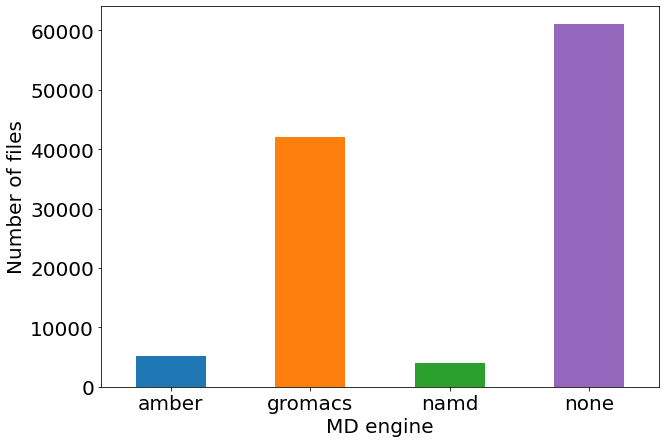

In [91]:
(tab
 .loc[:, "engine_MD"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", color=["tab:blue", "tab:orange", "tab:green", "tab:purple"], figsize=(10,7))
)
plt.xlabel("MD engine")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_MD_engine.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Number of files')

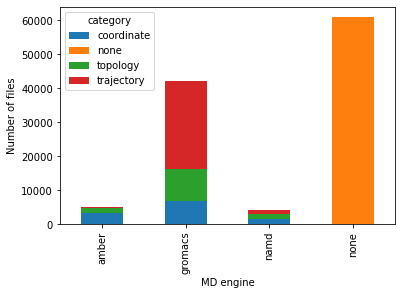

In [35]:
tab.groupby("engine_MD")["category"].value_counts().unstack().plot.bar(stacked=True)
plt.xlabel("MD engine")
plt.ylabel("Number of files")
# plt.savefig("Number_of_extensions_per_MDengine_with_categories.png")

#### Number of datasets per years

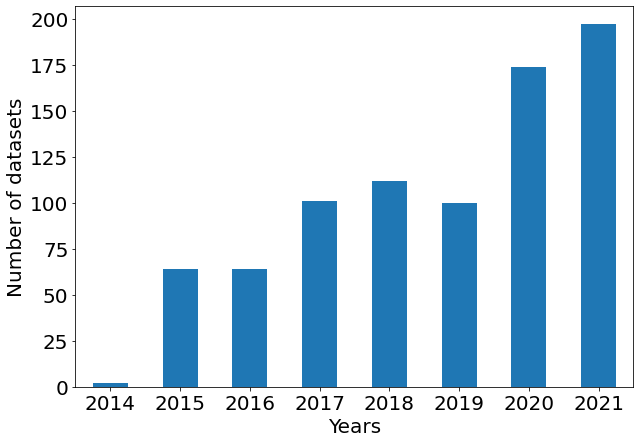

In [69]:
(datasets
 .query("year != 2022")
 .groupby(["year"])["dataset_id"]
 .size()
 .plot(kind="bar", figsize=(10,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of datasets")
plt.savefig("number_of_datasets_per_years.png", dpi=300, bbox_inches="tight")

### Number of files per years

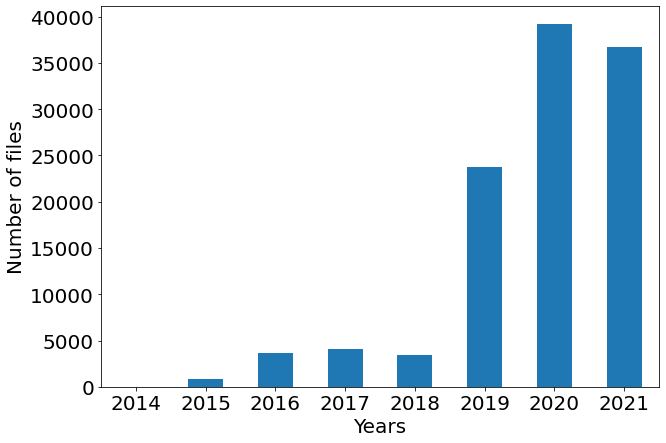

In [63]:
(tab
 .query("year != 2022")
 .loc[:, "year"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", figsize=(10,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_years.png", dpi=300, bbox_inches="tight")

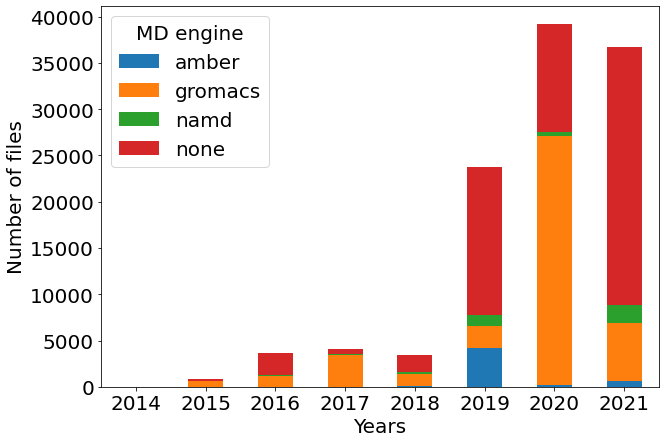

In [74]:
(tab
 .query("year != 2022")
 .groupby(["year", "engine_MD"])
 .size().unstack()
 .plot(kind="bar", stacked=True, figsize=(10,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.legend(title="MD engine")
plt.savefig("number_of_files_per_years_per_MD_engines.png", dpi=300, bbox_inches="tight")

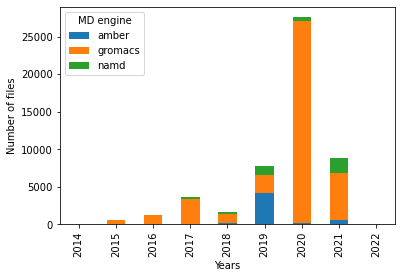

In [19]:
tab[tab["engine_MD"] != "none"].groupby(["years", "engine_MD"]).size().unstack().plot(kind="bar", stacked=True)
plt.xlabel("Years")
plt.ylabel("Number of files")
plt.legend(title="MD engine")
# plt.savefig("Number_of_files_per_years_with_categories_without_none.png")

### Number of files per filetype

For files not associated to MD engine.

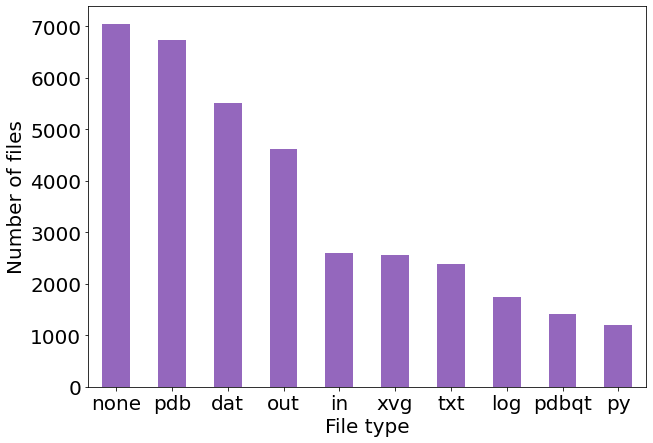

In [92]:
(tab
 .query("engine_MD == 'none'")
 .loc[:, "file_type"]
 .value_counts()
 .head(n=10)
 .plot(kind="bar", color="tab:purple", figsize=(10,7))
)
plt.xlabel("File type")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_filetype_no_MD_engine.png", dpi=300, bbox_inches="tight")

#### For Gromacs

Text(0, 0.5, 'Number of files')

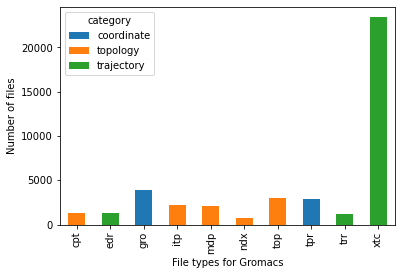

In [21]:
data_gromacs = tab[tab["file_type"].isin(ext_gromacs)]
data_gromacs[data_gromacs["engine_MD"] != "none"].groupby("file_type")["category"].value_counts().unstack().plot.bar(stacked=True)
plt.xlabel("File types for Gromacs")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_filetype_gromacs.png")

#### For Namd

Text(0, 0.5, 'Number of files')

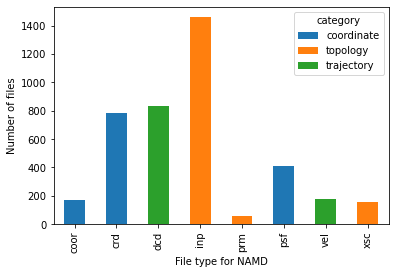

In [22]:
data_namd = tab[tab["file_type"].isin(ext_namd)]
data_namd[data_namd["engine_MD"] != "none"].groupby("file_type")["category"].value_counts().unstack().plot.bar(stacked=True)
plt.xlabel("File type for NAMD")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_filetype_namd.png")

#### For Amber

Text(0, 0.5, 'Number of files')

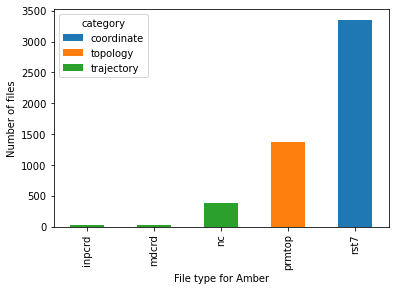

In [23]:
data_amber = tab[tab["file_type"].isin(ext_amber)]
data_amber[data_amber["engine_MD"] != "none"].groupby("file_type")["category"].value_counts().unstack().plot.bar(stacked=True)
plt.xlabel("File type for Amber")
plt.ylabel("Number of files")
# plt.savefig("Number_of_files_per_filetype_amber.png")

### File size per year

- in TB
- In Zenodo, individual file size cannot go above 50 GB (see [FAQ](https://help.zenodo.org/)).

In [24]:
(tab.groupby(["years"])["file_size"].sum()/10**12)

years
2014    0.000740
2015    0.156826
2016    0.144266
2017    1.216157
2018    1.183853
2019    1.338739
2020    2.647297
2021    1.932328
2022    0.006122
Name: file_size, dtype: float64

Text(0, 0.5, 'File size (in TB)')

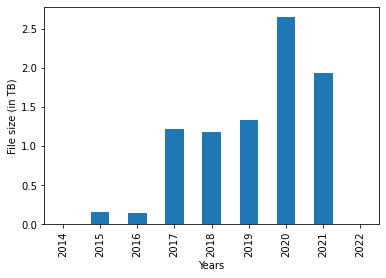

In [25]:
(tab.groupby(["years"])["file_size"].sum()/10**12).plot(kind="bar") 
plt.xlabel("Years")
plt.ylabel("File size (in TB)")
# plt.savefig("File_size_per_year.png")

### File size per MD engine

Text(0, 0.5, 'File size (in TB)')

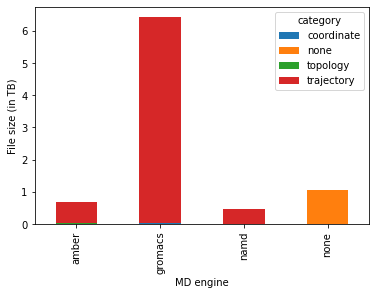

In [26]:
(tab.groupby(["engine_MD", "category"])["file_size"].sum()/10**12).unstack("category").plot(kind="bar", stacked=True)
plt.xlabel("MD engine")
plt.ylabel("File size (in TB)")
# plt.savefig("File_size_per_MDengine.png")

Text(0, 0.5, 'File size (in TB)')

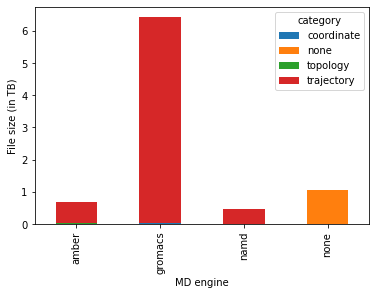

In [27]:
(tab.groupby(["engine_MD", "category"])["file_size"].sum()/10**12).unstack("category").plot(kind="bar", stacked=True)
plt.xlabel("MD engine")
plt.ylabel("File size (in TB)")
# plt.savefig("File_size_per_MDengine_with_categories.png")

### Comparison with figshare data

#### Load data

In [28]:
datasets_f = pd.read_csv("../figshare_datasets.tsv", sep="\t")
print(f"Found {datasets_f.shape[0]} datasets.")
files_f = pd.read_csv("../figshare_files.tsv", sep="\t")
print(f"Found {files_f.shape[0]} files.")

Found 1780 datasets.
Found 4295 files.


Merge both dataframes. One dataset can be associated to many files.

In [29]:
tab_f = pd.merge(files_f, datasets_f, how="left", on=["dataset_id", "origin"], validate="many_to_one")
print(f"Found {tab_f.shape[0]} rows.")

Found 4295 rows.


#### Extract year from date

In [30]:
tab_f["years"] = tab_f["date_creation"].apply(lambda x: int(x[:4]))
datasets_f["years"] = datasets_f["date_creation"].apply(lambda x: int(x[:4]))

#### Concatenation of data

In [31]:
tot = pd.concat([tab, tab_f])
datasets_tot = pd.concat([datasets, datasets_f])
print(f"Found {datasets.shape[0]} datasets.")
print(f"Found {datasets_f.shape[0]} datasets.")
print(f"Found {datasets_tot.shape[0]} datasets.")

Found 817 datasets.
Found 1780 datasets.
Found 2597 datasets.


#### Analysis

##### Number of datasets per years

Text(0, 0.5, 'Number of datasets')

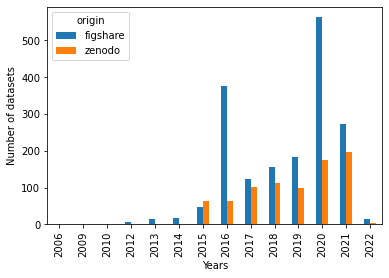

In [32]:
datasets_tot.groupby(["years", "origin"])["dataset_id"].size().unstack().plot(kind="bar", stacked=False)
plt.xlabel("Years")
plt.ylabel("Number of datasets")


##### Number of datasets per years

Text(0, 0.5, 'Number of files')

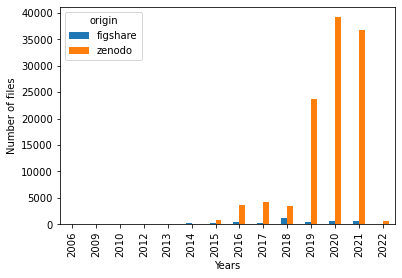

In [33]:
tot.groupby(["years", "origin"]).size().unstack().plot(kind="bar", stacked=False)
plt.xlabel("Years")
plt.ylabel("Number of files")